## Next-VolumeMap Prediction with Convolutional LSTMs 

> * https://www.youtube.com/watch?v=fmga0i0MXuU&feature=youtu.be 
> * Code: https://github.com/lukas/ml-class/tree/master/videos/video-predict 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import h3
import json
import folium
from geojson.feature import *
import branca.colormap as cm 
from folium import Map, Marker, GeoJson 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox 

In [3]:
use_columns = ['date', 'from_lat', 'from_lon', 'status', 'geozone_id']

incoming_orders = pd.read_csv("mytaxi_test_max_taxi_incoming_orders.csv", usecols=use_columns)

incoming_orders = incoming_orders[incoming_orders.status == 7][:]
# incoming_orders = incoming_orders[incoming_orders.geozone_id == 3][:]   

incoming_orders.drop(columns=['status', 'geozone_id'], inplace=True)

In [4]:
hexagons_gridDF = pd.read_csv("hexagons_grid.csv") 

In [5]:
incoming_orders['date'] = incoming_orders['date'].astype('datetime64[ns]')  

print("Min date: {}".format(incoming_orders['date'].min()))
print("Max date: {}".format(incoming_orders['date'].max()))

Min date: 2021-01-01 00:01:06
Max date: 2022-02-28 23:59:21


In [6]:
def get_volume_map(df, hex_df): 
    ## only keeping long, lat 
    
    if df.shape[0] > 0: 
        df = df[["from_lat", "from_lon"]] 

        df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["from_lat"], row["from_lon"], resolution), axis = 1) 

        df = df.groupby(by = "hex_id").size().reset_index() 
        df.columns = ["hex_id", "value"] 

        ### merging with hex_df 
        df = pd.merge(hex_df, df, on='hex_id', how='left')  
        df.fillna(0, inplace=True) 

        ### sort 
        df.sort_values(by='hex_id', inplace=True)  

        ### generating 28x28 numpy volume map  
        volume_map = df['value'].values.reshape((28, 28)) 
    else: 
        volume_map = np.zeros((28, 28))

    return volume_map 

In [7]:
interval = 10 

volume_maps = np.load("volume_maps_interval_{}.npy".format(interval))

In [8]:
len(volume_maps) 

61055

In [9]:
train = volume_maps[:60000]   ## for train: 4000 frames 
test  = volume_maps[60000:]   ## for test: 415 frames 

In [10]:
def make_sequence(data, sequence_length): 
    main_list = [] 
    
    for i in range(len(data) - sequence_length): 
        l = data[i:i+sequence_length]
        l = np.array(l)
        main_list.append(l)
    
    return np.array(main_list)

In [11]:
sequence_length = 5 

train_dataset = make_sequence(train, sequence_length)
test_dataset  = make_sequence(test, sequence_length)

# Add a channel dimension since the images are grayscale.
train_dataset = np.expand_dims(train_dataset, axis=-1)
test_dataset  = np.expand_dims(test_dataset, axis=-1)

print("[!] Shape of train sequence: {}".format(train_dataset.shape))
print("[!] Shape of test sequence:  {}".format(test_dataset.shape))

[!] Shape of train sequence: (59995, 5, 28, 28, 1)
[!] Shape of test sequence:  (1050, 5, 28, 28, 1)


Displaying volume maps for example 59340.


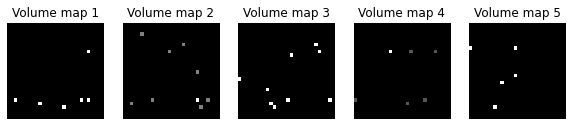

In [12]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Volume map {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying volume maps for example {data_choice}.")
plt.show() 

In [13]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 4 : data.shape[1], :, :]
    return x, np.squeeze(y, axis=1)

In [14]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
test_dataset = test_dataset / 255

In [15]:
from tensorflow.keras import backend as K 

# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    b = y_true[:, :, :, 0] - y_pred[:, :, :, 0]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

In [16]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(test_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (59995, 4, 28, 28, 1), (59995, 28, 28, 1)
Validation Dataset Shapes: (1050, 4, 28, 28, 1), (1050, 28, 28, 1)


In [18]:
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D

from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

# wandb.init(config=hyperparams)
# config = wandb.config

c=4

inp = Input((4, 28, 28, 1))
# reshaped = Reshape((28,28,4,1))(inp)     # input_shape=(96,96,3,5) 
permuted = Permute((2,3,4,1))(inp)
last_layer = Lambda(slice, input_shape=(28,28,1,4), output_shape=(28,28,1))(permuted)
# x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(inp)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(1, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])
# model=Model(inputs=[inp], outputs=x) 

# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer="adam", loss='mse', metrics=[perceptual_distance])  # adam, binary_crossentropy 

# Define modifiable training hyperparameters.
epochs = 35
batch_size = 16

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
)
model.summary()

Train on 59995 samples, validate on 1050 samples
Epoch 1/35
59995/59995 [==============================] - 453s 8ms/step - loss: 0.0030 - perceptual_distance: 9.2256 - val_loss: 4.3596e-06 - val_perceptual_distance: 0.6550
Epoch 2/35
59995/59995 [==============================] - 448s 7ms/step - loss: 1.2227e-05 - perceptual_distance: 1.0757 - val_loss: 2.1510e-06 - val_perceptual_distance: 0.3964
Epoch 3/35
59995/59995 [==============================] - 471s 8ms/step - loss: 3.1365e-06 - perceptual_distance: 0.5500 - val_loss: 1.9640e-06 - val_perceptual_distance: 0.3351
Epoch 4/35
59995/59995 [==============================] - 457s 8ms/step - loss: 1.9635e-06 - perceptual_distance: 0.4321 - val_loss: 2.7577e-06 - val_perceptual_distance: 0.6060
Epoch 5/35
59995/59995 [==============================] - 469s 8ms/step - loss: 2.0569e-06 - perceptual_distance: 0.4200 - val_loss: 1.8475e-06 - val_perceptual_distance: 0.3256
Epoch 6/35
59995/59995 [==============================] - 479s 8m

Displaying volume maps for example 59340.


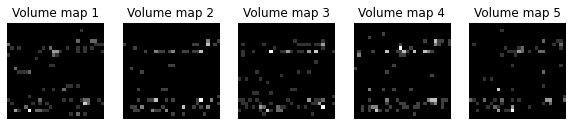

In [94]:
# Select a random example from the validation dataset.
example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]

# example = test_dataset[2972]

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(example[idx]), cmap="gray")
    ax.set_title(f"Volume map {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying volume maps for example {data_choice}.")
plt.show() 

In [95]:
# Pick the first/last ten frames from the example.
frames = example[:4, ...]
original_frames = example[1:, ...]

# Predict a new set
new_prediction = model.predict(np.expand_dims(frames, axis=0))
# new_prediction = np.squeeze(new_prediction, axis=0)
# predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

In [96]:
new_prediction[0].shape

(28, 28, 1)

Predicted map


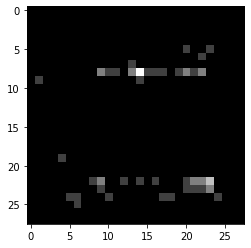

In [97]:
print("Predicted map")

plt.figure(figsize = (4, 4))

plt.imshow(np.round(new_prediction[0]*255, 0) , cmap='gray', interpolation='nearest')
plt.show()

In [98]:
(np.round(new_prediction[0]*255, 1)).sum()

117.2

In [99]:
(example[-1, ...]*255).sum()

86.0

Original map


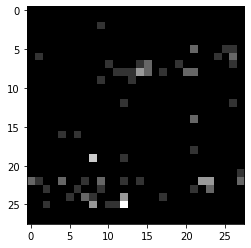

In [100]:
print("Original map")

plt.figure(figsize = (4, 4))

plt.imshow(example[-1, ...]*255, cmap='gray', interpolation='nearest')
plt.show()